In [1]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')

if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [2]:
from __future__ import print_function, division

from collections import Counter, OrderedDict

import hosts
import targeting
import mmthecto
import numpy as np

from astropy import units as u
from astropy.coordinates import *
from astropy import table
from astropy.visualization import hist as ahist

In [77]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (16, 10)
plt.rcParams['image.cmap'] = 'viridis'

In [4]:
proposed_targets = [126115,129461,154119,21709,129237,132339]

# Choose hosts and Load stuff

In [5]:
hostlst = hosts.get_saga_hosts_from_google() #'named' hosts

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [14]:
hosts_to_target = []
for nsanum in (126115,129461,154119,21709,129237,132339):
    for h in hostlst:
        if h.nsaid == nsanum:
            hosts_to_target.append(h)
            break
    else:
        # new target
        hosts_to_target.append(hosts.NSAHost(nsanum))
hosts_to_target

[<hosts.NSAHost object w/ name 'Bandamanna' AKA: ['NGC7818', 'NSA126115']>,
 <hosts.NSAHost object w/ name 'NSA129461'>,
 <hosts.NSAHost object w/ name 'NSA154119'>,
 <hosts.NSAHost object w/ name 'NSA21709'>,
 <hosts.NSAHost object w/ name 'NSA129237'>,
 <hosts.NSAHost object w/ name 'Narnia' AKA: ['NGC1015', 'NSA132339']>]

In [15]:
# now set to the latest base catalogs
for h in hosts_to_target:
    h.fnsdss = 'SAGADropbox/base_catalogs/base_sql_nsa{0}.fits.gz'.format(h.nsaid)
    h._cached_sdss = None

In [16]:
# actually make sure they're loaded
torem = []
for h in hosts_to_target:
    try:
        h.get_sdss_catalog()
    except IOError:
        torem.append(h)
        print('Failed to load base catalog for', h, 'so removing from hosts_to_target')
        
hosts_to_target_orig = hosts_to_target[:]
for h in torem:
    hosts_to_target.remove(h)

Failed to load base catalog for <hosts.NSAHost object w/ name 'NSA129461'> so removing from hosts_to_target


In [19]:
# preview the catalog
hosts_to_target[0].get_sdss_catalog()

OBJID,RA,DEC,PHOTPTYPE,PHOT_SG,FLAGS,clean,SATURATED,BAD_COUNTS_ERROR,BINNED1,TOO_FEW_GOOD_DETECTIONS,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,MODELMAGERR_U,MODELMAGERR_G,MODELMAGERR_R,MODELMAGERR_I,MODELMAGERR_Z,EXTINCTION_U,EXTINCTION_G,EXTINCTION_R,EXTINCTION_I,EXTINCTION_Z,DERED_U,DERED_G,DERED_R,DERED_I,DERED_Z,PETRORAD_U,PETRORAD_G,PETRORAD_R,PETRORAD_I,PETRORAD_Z,PETRORADERR_U,PETRORADERR_G,PETRORADERR_R,PETRORADERR_I,PETRORADERR_Z,DEVRAD_U,DEVRADERR_U,DEVRAD_G,DEVRADERR_G,DEVRAD_R,DEVRADERR_R,DEVRAD_I,DEVRADERR_I,DEVRAD_Z,DEVRADERR_Z,DEVAB_U,DEVAB_G,DEVAB_R,DEVAB_I,DEVAB_Z,CMODELMAG_U,CMODELMAGERR_U,CMODELMAG_G,CMODELMAGERR_G,CMODELMAG_R,CMODELMAGERR_R,CMODELMAG_I,CMODELMAGERR_I,CMODELMAG_Z,CMODELMAGERR_Z,PSFMAG_U,PSFMAGERR_U,PSFMAG_G,PSFMAGERR_G,PSFMAG_R,PSFMAGERR_R,PSFMAG_I,PSFMAGERR_I,PSFMAG_Z,PSFMAGERR_Z,FIBERMAG_U,FIBERMAGERR_U,FIBERMAG_G,FIBERMAGERR_G,FIBERMAG_R,FIBERMAGERR_R,FIBERMAG_I,FIBERMAGERR_I,FIBERMAG_Z,FIBERMAGERR_Z,FRACDEV_U,FRACDEV_G,FRACDEV_R,FRACDEV_I,FRACDEV_Z,Q_U,U_U,Q_G,U_G,Q_R,U_R,Q_I,U_I,Q_Z,U_Z,EXPAB_U,EXPRAD_U,EXPPHI_U,EXPAB_G,EXPRAD_G,EXPPHI_G,EXPAB_R,EXPRAD_R,EXPPHI_R,EXPAB_I,EXPRAD_I,EXPPHI_I,EXPAB_Z,EXPRAD_Z,EXPPHI_Z,FIBER2MAG_R,FIBER2MAGERR_R,EXPMAG_R,EXPMAGERR_R,PETROR50_R,PETROR90_R,PETROMAG_R,SB_EXP_R,SB_PETRO_R,J,JERR,H,HERR,K,KERR,SPEC_Z,SPEC_Z_ERR,SPEC_Z_WARN,PHOTOZ,PHOTOZ_ERR,W1,W1ERR,W2,W2ERR,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_MR,HOST_MG,HOST_NSAID,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,PROBABILITY_CLASS1,RESCALED_PROBABILITY_CLASS1,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_CLASS,SPECOBJID,SPEC_REPEAT,Ai,fibermag_z,rhost,fibermag_r,fibermag_u,Ag,fibermag_i,Az,Ar,dec,Au,fibermag_g,type,ra,objID,psf_r,psf_u,psf_z,rhost_kpc,phot_sg,psf_g,psf_i,U,B,V,R,I,psf_U,psf_B,psf_V,psf_R,psf_I
int64,float64,float64,int16,str40,int64,int32,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str48,float64,float64,int64,int64,float64,float64,int64,str6,str48,int64,str2,str48,str48,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float32,float32,int16,float64,int64,float32,float32,float32,float64,str40,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1237680247351672957,0.995575122267,20.7524099889,3,GALAXY,105656498651152,1,0,0,268435456,0,14.2853,12.8044,11.9377,11.4279,11.0222,0.00949019,0.000935407,0.000573401,0.000569579,0.00146553,0.258206,0.0426484,0.024065,0.0183603,0.0302881,0.299514,0.22038,0.159838,0.1212,0.0859324,21.4993,20.4597,19.3215,18.5531,17.9055,1.32235,1.34169,1.37461,1.43516,1.49363,0.353329,0.104188,0.0561147,0.0433549,0.0759478,0.00412682,22.6817,0.0101819,2.49969,0.159861,0.0392906,0.240542,0.0350321,0.262777,0.0802993,0.110489,0.0803386,0.999782,0.999706,0.995768,21.8616,0.911032,20.7695,0.0632721,19.4814,0.0246741,18.5847,0.0182752,17.8988,0.0326979,21.8349,0.326354,20.7707,0.138882,19.6115

In [20]:
# these are the already-observed objects
spectra = h.load_and_reprocess_sdss_catalog('SAGADropbox/data/saga_spectra_clean_jan15.fits.gz')

# Ranking 

In [72]:
ranktab = """
1 | Flux Stars
2 | Special targets
3 | r<300 kpc, ugri cuts, M_r<20
4 | r<300 kpc, ugri cuts, M_r<20.75
5 | r<300 kpc, gri cuts, M_r<20.75
6 | 300<r<450 kpc, ugri cuts, M_r<20.75
7 | 300<r<450 kpc, gri cuts, M_r<20.75
8 | other
"""[1:-1]
ranktab = dict([line.split('|') for line in ranktab.split('\n')])

{'1 ': ' Flux Stars',
 '2 ': ' Special targets',
 '3 ': ' r<300 kpc, ugri cuts, M_r<20',
 '4 ': ' r<300 kpc, ugri cuts, M_r<20.75',
 '5 ': ' r<300 kpc, gri cuts, M_r<20.75',
 '6 ': ' 300<r<450 kpc, ugri cuts, M_r<20.75',
 '7 ': ' 300<r<450 kpc, gri cuts, M_r<20.75',
 '8 ': ' other'}

The ugr cut is:   ug > (1.5*gr) -0.25
(that's the *cut*, not the accept condition)

## Fix up 154119 

In [100]:
h = hosts_to_target[1]
cat = h.get_sdss_catalog()
scs = SkyCoord(cat['RA'], cat['DEC'], unit=u.deg)
cat['RHOST_ARCM'] = scs.separation(h.coords).to(u.arcmin).value
cat['RHOST_KPC'] = scs.separation(h.coords).to(u.radian).value * h.distmpc*1000

In [102]:
def rank_targets(cat):
    corrmag = {band: cat[band] - cat['A'+band]  for band in 'ugri'}
    
    phot_good = (cat['r']<21.25)& (cat['fibermag_r']<23)&(cat['phot_sg']=='GALAXY')
    
    gmr_wunc = corrmag['g']- corrmag['r'] - 2*np.hypot(cat['g_err'], cat['r_err'])
    rmi_wunc = corrmag['r']- corrmag['i'] - 2*np.hypot(cat['g_err'], cat['r_err'])
    
    gmr_accept = gmr_wunc <= 0.85
    rmi_accept = rmi_wunc <= 0.55
    ug_cut = corrmag['u'] - corrmag['g'] < (1.5*(corrmag['g'] - corrmag['r']) - 0.25)
    
    gri_accept  = gmr_accept&gmr_accept
    ugri_accept  = gri_accept&~ug_cut
    
    r_bright = corrmag['r'] < 20.
    r_ok = corrmag['r'] < 20.75
    r_faint = r_ok&~r_bright
    
    near = cat['RHOST_KPC']<300
    nearish = (cat['RHOST_KPC']<450) & ~near
    
    ranks = np.zeros(len(cat), dtype=int)
    
    
    ranks[r_ok & gri_accept & nearish & phot_good] = 7
    ranks[r_ok & ugri_accept & nearish & phot_good] = 6
    ranks[r_ok & gri_accept & near & phot_good] = 5
    ranks[r_ok & ugri_accept & near & phot_good] = 4
    ranks[r_bright & ugri_accept & near & phot_good] = 3
    
    ranks[(ranks==0)&phot_good] = 8  # other
    
    do_checks(cat, ranks)
    
    return ranks

def do_checks(cat, ranks):
    
    zq = cat['ZQUALITY'].copy()
    # ranks ~-100 are removed due to already-observed
    havespec = zq>=3
    ranks[havespec] = -100 - zq[havespec]
    
    # this *shouldn't* be necessary, as ZQUALITY should be in the base catalog.  
    # But as a sanity check we look to see if anything in the spectral catalog is still being included
    spec_this_host = spectra[spectra['HOST_NSAID']==h.nsaid]
    spec_this_host = spec_this_host[np.in1d(spec_this_host['OBJID'], cat['OBJID'])]

    for i, zqi in zip(spec_this_host['OBJID'], spec_this_host['ZQUALITY']):
        zq[cat['OBJID']==i] = zqi
    if np.any(ranks[zq>2]>=0):
        print('POSSIBLE PROBLEM: Found some objects in spectrum list that are *not* claimed ' 
              'as having spectra in the base catalogs.  Setting them to -11x:', dict(Counter(ranks[ranks<-110])))
        ranks[zq>2] = -110 - zq[zq>2]
    
    # remove list
    tokeep = cat['REMOVE']==-1
    ranks[~tokeep] = -cat['REMOVE'][~tokeep] # sets the REMOVE objects to -their remove value
    remmskval =  np.min(ranks)-1
    # remove anything in the remove list online but not in the catalog as remove
    ranks[~targeting.remove_targets_with_remlist(cat, h, maskonly=True, verbose='warning')&(ranks>-1)] = remmskval
    if np.sum(ranks==remmskval) > 0:
        print('Removed', np.sum(ranks==remmskval), 'due to online remove list. Remmsk val:', remmskval)
    
    #de-duplicate
    if len(np.unique(cat['OBJID'])) != len(cat):
        _, idxs = np.unique(cat['OBJID'], return_index=True)
        msk = np.ones_like(cat, dtype=bool)
        msk[idxs] = 0
        ranks[msk] = -1000
        
        print('WARNING: some duplicate objid found.  Setting', np.sum(ranks==-1000), 'dupes to pri=-1000')


In [103]:
for h in hosts_to_target:
    print('On host', h.name)
    cat = h.get_sdss_catalog()

    cat['mmt_ranks'] = rank_targets(cat)
    print(Counter(cat['mmt_ranks']), end='\n\n')

On host Bandamanna
Counter({0: 38678, -3: 12218, 8: 8821, 6: 867, -104: 533, 7: 517, 5: 359, 4: 334, 3: 305, -2: 81, -4: 47, -1: 31, -1000: 8})

On host NSA154119
No matches found for host "NSA154119" in remove list. Maybe you mis-typed something?
Counter({0: 51421, 8: 9881, -3: 5055, 6: 1136, -104: 767, 7: 575, 5: 498, 3: 489, 4: 480, -2: 368, -4: 72, -1000: 11})

On host NSA21709
No matches found for host "NSA21709" in remove list. Maybe you mis-typed something?
Counter({0: 47824, 8: 10084, -3: 4580, 6: 1292, 7: 728, 4: 514, 5: 474, 3: 398, -2: 169, -104: 167, -4: 32, -1000: 10, -1: 1})

On host NSA129237
POSSIBLE PROBLEM: Found some objects in spectrum list that are *not* claimed as having spectra in the base catalogs.  Setting them to -11x: {}
Counter({0: 40954, -3: 12988, 8: 7557, -114: 724, 6: 644, 7: 349, 5: 343, 4: 258, 3: 244, -2: 172, -113: 49, -4: 45, -1: 42, -1000: 15})

On host Narnia
POSSIBLE PROBLEM: Found some objects in spectrum list that are *not* claimed as having sp

# Plot catalogs w/ ranks 

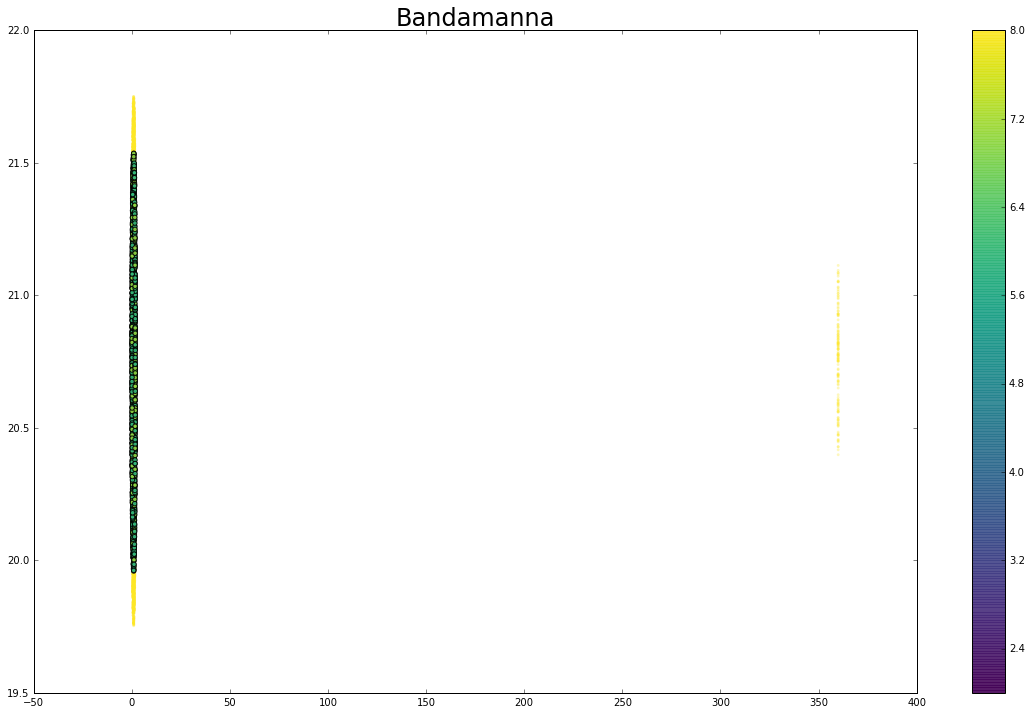

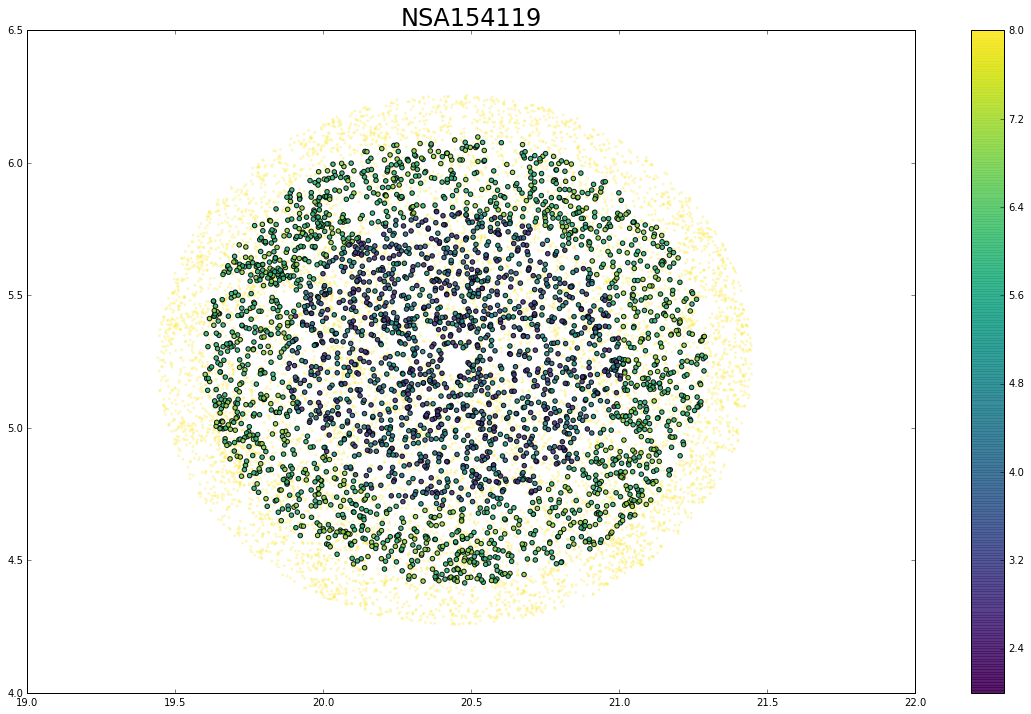

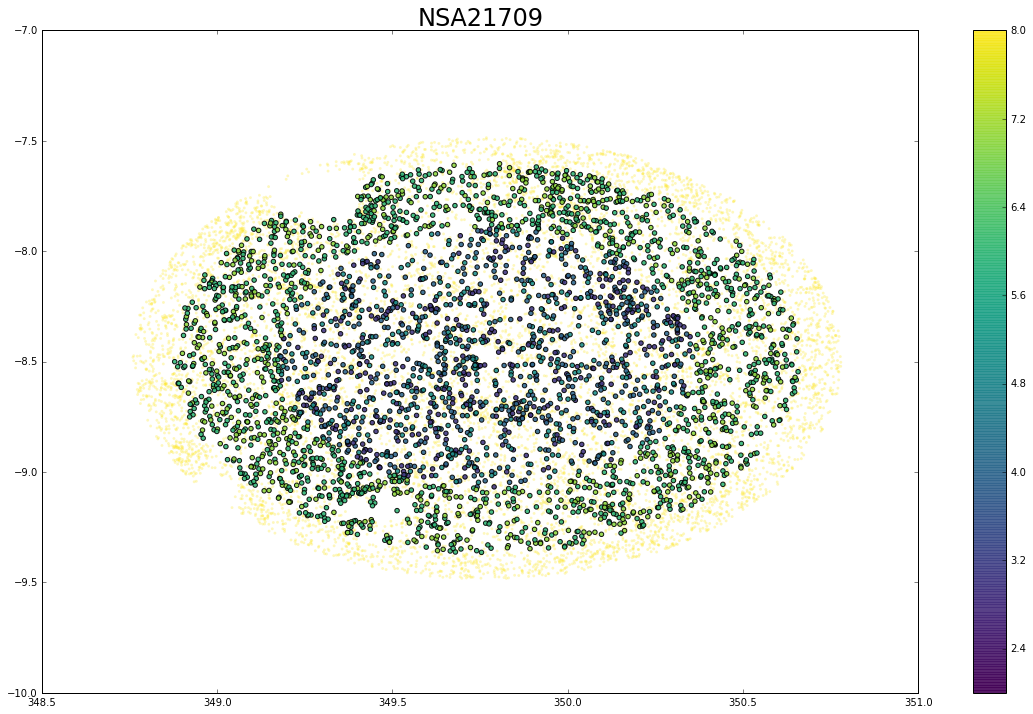

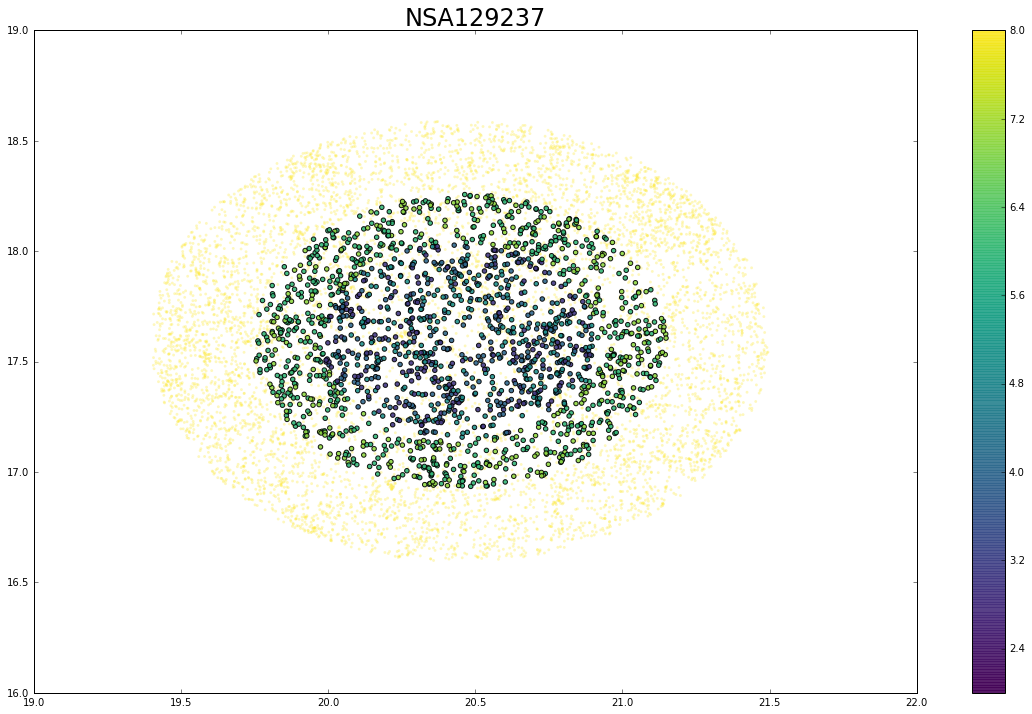

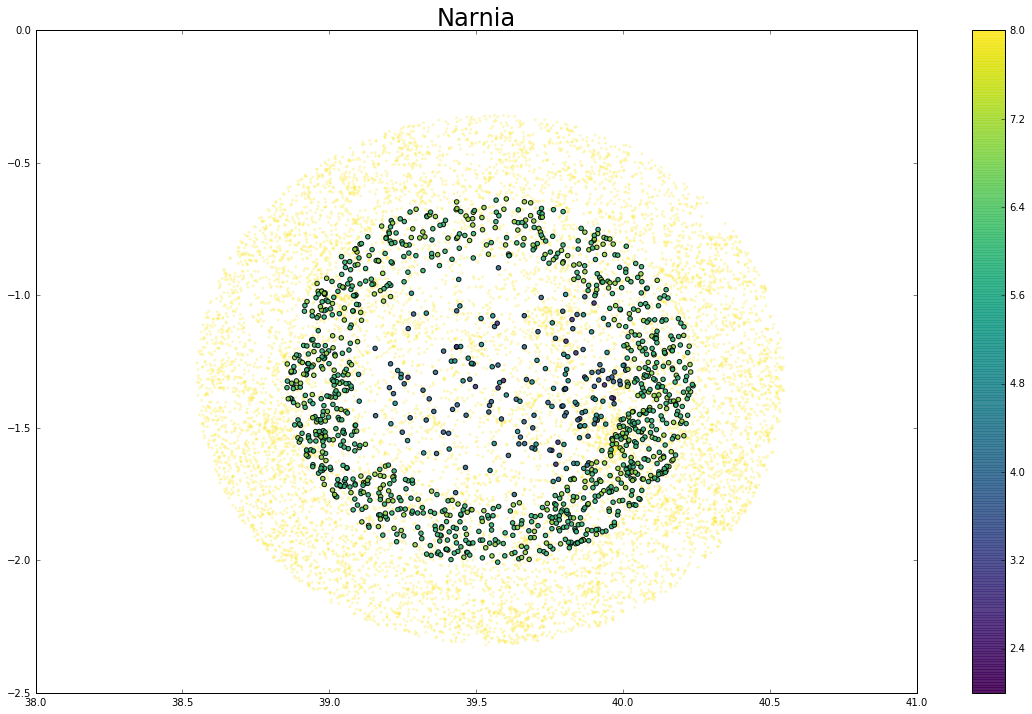

In [104]:
for h in hosts_to_target:
    cat = h.get_sdss_catalog()
    ranks = cat['mmt_ranks']

    plt.figure()
    
    msk_good = (ranks>1)&(ranks<8)
    msk_bad = (ranks>7)
    
    plt.scatter(cat['ra'][msk_bad], cat['dec'][msk_bad], 
                lw=0, alpha=.3, c=ranks[msk_bad],s=8, vmin=2, vmax=np.max(ranks))
    plt.scatter(cat['ra'][msk_good], cat['dec'][msk_good], 
                lw=1, alpha=.9, c=ranks[msk_good],s=20, vmin=2, vmax=np.max(ranks))
    
    plt.colorbar()
    
    
    plt.title(h.name, fontsize=24)
    
    plt.tight_layout()

# Generate Catalogs 

In [105]:
generated_cats = {}
for h in hosts_to_target:
    print('On host', h.name)
    sys.stdout.flush()

    cat = h.get_sdss_catalog()
    ranks = cat['mmt_ranks']
    
    fnout = 'mmthecto/{0}_oct2016.cat'.format(h.name)
    fluxfnout = fnout.replace('.cat', '.fluxstars')
    print('Going to write', fnout)
    
    msk = (cat['RHOST_ARCM']<40) & (ranks>0) & (ranks<8)
    generated_cats[h] = mmthecto.generate_catalog(h, cat[msk], ranks[msk], 
                                         repeatflux=3, removefluxdistance=(1*u.arcmin,ranks[msk]<8),
                                         fnout=fnout, fluxfnout=fluxfnout)

On host Bandamanna
Going to write mmthecto/Bandamanna_oct2016.cat
Including 1620 targets
Found 86 Flux stars
Removing 27 Flux stars too close to program stars
Found 447 guide stars
On host NSA154119
Going to write mmthecto/NSA154119_oct2016.cat
Including 1977 targets
Found 55 Flux stars
Removing 19 Flux stars too close to program stars
Found 316 guide stars
On host NSA21709
Going to write mmthecto/NSA21709_oct2016.cat
Including 1872 targets
Found 87 Flux stars
Removing 27 Flux stars too close to program stars
Found 368 guide stars
On host NSA129237
Going to write mmthecto/NSA129237_oct2016.cat
Including 1833 targets
Found 49 Flux stars
Removing 14 Flux stars too close to program stars
Found 339 guide stars
On host Narnia
Going to write mmthecto/Narnia_oct2016.cat
Including 1100 targets
Found 46 Flux stars
Removing 9 Flux stars too close to program stars
Found 270 guide stars
